In [1]:
import os
import json
from typing import Any

from PIL import Image
import torch
import torchvision
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from torchvision import transforms
from torchvision import tv_tensors
from torch.utils.data.dataset import Dataset
from torchvision.datasets import CocoDetection
from torch.utils.data.dataloader import DataLoader
from torchvision.transforms.v2 import functional as tf2

In [80]:
import torchvision.transforms.functional


class CocoSegmentationDataset(Dataset):
    def __init__(self, split : str = 'train', transform=None) -> None:
        super().__init__()
        self.files_path = f'../coco/images/{split}2017/'
        self.ann_file = f'../coco/annotations/instances_{split}2017.json'
        self.pixemaps_path = f'../coco/annotations/{split}2017/'

        self.inputs = list(sorted(os.listdir(self.files_path)))[:1000]
        self.targets = list(sorted(os.listdir(self.pixemaps_path)))[:1000]
        with open(self.ann_file, 'r') as file:
            data = json.load(file)

        self.image_info = data['images']
        # print(data['images'][:10])
        self.annotations = data['annotations']

        # print(self.inputs[:10])
        # print(self.targets[:10])
        # print(self.annotations[:10])

        self.transform = transform# transforms.Compose([transforms.ToTensor()])

    def _load_image(self, path: str) -> Image.Image:
        return Image.open(path).convert("RGB")

    def __len__(self) -> int:
        return len(self.inputs)
    
    def __getitem__(self, index) -> Any:

        image = self._load_image(self.files_path + self.inputs[index])
        pixel_map = self._load_image(self.pixemaps_path + self.targets[index])
        # print(image.size)
        # print(pixel_map.size)

        image_id = [x for x in self.image_info if x['file_name'] == self.inputs[index]][0]['id']
        # print(image_info)
        target = [x for x in self.annotations if x['image_id'] == image_id]
        print(target)
        bboxes = [x['bbox'] for x in target]
        category_id = [x['category_id'] for x in target]
        iscrowd = [x['iscrowd'] for x in target]
        image_ids = [x['image_id'] for x in target]
        area = [x['area'] for x in target]
        # print(bboxes)
        # masks = [x['bbox'] for x in target]
       #  print(len(target))
        # print(type(target))
        # target = self.annotations[index]        
        tgt = {}
        tgt['boxes'] = tv_tensors.BoundingBoxes(bboxes, format="xywh", canvas_size=tf2.get_size(image))
        # print(tgt['boxes'])
        # tgt['boxes'] = torchvision.ops.box_convert(tgt['boxes'], "xywh", "xyxy")
        tgt['masks'] = tv_tensors.Mask(pixel_map)
        tgt['labels'] = torch.Tensor(category_id)
        tgt['iscrowd'] = torch.Tensor(iscrowd)
        tgt['image_id'] = torch.Tensor(image_ids)
        tgt['area'] = torch.Tensor(area)

        if self.transform is not None:
            image, tgt = self.transform(image, tgt)
            # tgt = self.transform(tgt)
            # pixel_map = self.transform(pixel_map)
            
        # return torchvision.transforms.functional.pil_to_tensor(image).float(), tgt, pixel_map
        return image, tgt, pixel_map

In [83]:
from torchvision.transforms import v2 as T


from torchvision.transforms import v2 as T


def get_transform(train):
    transforms = []
    # if train:
    #     transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.PILToTensor())
    transforms.append(T.ToDtype(torch.float, scale=False))
    transforms.append(T.ToPureTensor())
    # transforms.append(T.SanitizeBoundingBoxes())
    # transforms.append(T.ToTensor())
    # transforms.append(T.ToTensor())
    return T.Compose(transforms)

dataset = CocoSegmentationDataset('train', get_transform(True))
loader = DataLoader(dataset, batch_size=1)

In [84]:
_, tgt, _ = dataset[0]

[{'segmentation': [[500.49, 473.53, 599.73, 419.6, 612.67, 375.37, 608.36, 354.88, 528.54, 269.66, 457.35, 201.71, 420.67, 187.69, 389.39, 192.0, 19.42, 360.27, 1.08, 389.39, 2.16, 427.15, 20.49, 473.53]], 'area': 120057.13925, 'iscrowd': 0, 'image_id': 9, 'bbox': [1.08, 187.69, 611.59, 285.84], 'category_id': 51, 'id': 1038967}, {'segmentation': [[357.03, 69.03, 311.73, 15.1, 550.11, 4.31, 631.01, 62.56, 629.93, 88.45, 595.42, 185.53, 513.44, 230.83, 488.63, 232.99, 437.93, 190.92, 429.3, 189.84, 434.7, 148.85, 410.97, 121.89, 359.19, 74.43, 358.11, 65.8]], 'area': 44434.751099999994, 'iscrowd': 0, 'image_id': 9, 'bbox': [311.73, 4.31, 319.28, 228.68], 'category_id': 51, 'id': 1039564}, {'segmentation': [[249.6, 348.99, 267.67, 311.72, 291.39, 294.78, 304.94, 294.78, 326.4, 283.48, 345.6, 273.32, 368.19, 269.93, 385.13, 268.8, 388.52, 257.51, 393.04, 250.73, 407.72, 240.56, 425.79, 230.4, 441.6, 229.27, 447.25, 237.18, 447.25, 256.38, 456.28, 254.12, 475.48, 263.15, 486.78, 271.06, 49

In [13]:
import matplotlib.patches as patches

for x in range(len(dataset))[:5]:
    img, target, _ = dataset[x]
    fig, ax = plt.subplots()
    ax.imshow(img)
    # print(target)

    # for tgt in target:
    #     rect = patches.Rectangle((tgt['bbox'][0], tgt['bbox'][1]), tgt['bbox'][2], tgt['bbox'][3], linewidth=1, edgecolor='r', facecolor='none')
    #     ax.add_patch(rect)

TypeError: new(): data must be a sequence (got Image)

In [8]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [9]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

In [86]:
from torchvision.transforms import v2 as T


def get_transform(train):
    transforms = []
    # if train:
    #     transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.PILToTensor())
    transforms.append(T.ToDtype(torch.float, scale=False))
    transforms.append(T.ToPureTensor())
    # transforms.append(T.SanitizeBoundingBoxes())
    # transforms.append(T.ToTensor())
    # transforms.append(T.ToTensor())
    return T.Compose(transforms)

In [87]:
def collate_fn(batch):
    return tuple(zip(*batch))

dataset = CocoSegmentationDataset('train', transform=get_transform(True))

In [88]:
loader = DataLoader(dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

In [89]:
# For Training
images, targets, _ = next(iter(loader))

images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
# print(targets)
output = model(images, targets)  # Returns losses and detections
print(output)


[{'segmentation': [[500.49, 473.53, 599.73, 419.6, 612.67, 375.37, 608.36, 354.88, 528.54, 269.66, 457.35, 201.71, 420.67, 187.69, 389.39, 192.0, 19.42, 360.27, 1.08, 389.39, 2.16, 427.15, 20.49, 473.53]], 'area': 120057.13925, 'iscrowd': 0, 'image_id': 9, 'bbox': [1.08, 187.69, 611.59, 285.84], 'category_id': 51, 'id': 1038967}, {'segmentation': [[357.03, 69.03, 311.73, 15.1, 550.11, 4.31, 631.01, 62.56, 629.93, 88.45, 595.42, 185.53, 513.44, 230.83, 488.63, 232.99, 437.93, 190.92, 429.3, 189.84, 434.7, 148.85, 410.97, 121.89, 359.19, 74.43, 358.11, 65.8]], 'area': 44434.751099999994, 'iscrowd': 0, 'image_id': 9, 'bbox': [311.73, 4.31, 319.28, 228.68], 'category_id': 51, 'id': 1039564}, {'segmentation': [[249.6, 348.99, 267.67, 311.72, 291.39, 294.78, 304.94, 294.78, 326.4, 283.48, 345.6, 273.32, 368.19, 269.93, 385.13, 268.8, 388.52, 257.51, 393.04, 250.73, 407.72, 240.56, 425.79, 230.4, 441.6, 229.27, 447.25, 237.18, 447.25, 256.38, 456.28, 254.12, 475.48, 263.15, 486.78, 271.06, 49

AssertionError: All bounding boxes should have positive height and width. Found invalid box [626.608154296875, 67.26666259765625, 125.83797454833984, 77.54999542236328] for target at index 0.

In [90]:
targets

[{'boxes': tensor([[  1.0800, 187.6900, 611.5900, 285.8400],
          [311.7300,   4.3100, 319.2800, 228.6800],
          [249.6000, 229.2700, 316.2400, 245.0800],
          [  0.0000,  13.5100, 434.4800, 375.1200],
          [376.2000,  40.3600,  75.5500,  46.5300],
          [465.7800,  38.9700,  58.0700,  46.6700],
          [385.7000,  73.6600,  84.0200,  70.5100],
          [364.0500,   2.4900,  94.7600,  71.0700]]),
  'masks': tensor([[[164, 164, 164,  ..., 142, 142, 142],
           [164, 164, 164,  ..., 142, 142, 142],
           [164, 164, 164,  ..., 142, 142, 142],
           ...,
           [142, 142, 142,  ..., 142, 142, 142],
           [142, 142, 142,  ..., 142, 142, 142],
           [142, 142, 142,  ..., 142, 142, 142]],
  
          [[164, 164, 164,  ..., 142, 142, 142],
           [164, 164, 164,  ..., 142, 142, 142],
           [164, 164, 164,  ..., 142, 142, 142],
           ...,
           [142, 142, 142,  ..., 142, 142, 142],
           [142, 142, 142,  ..., 142, 

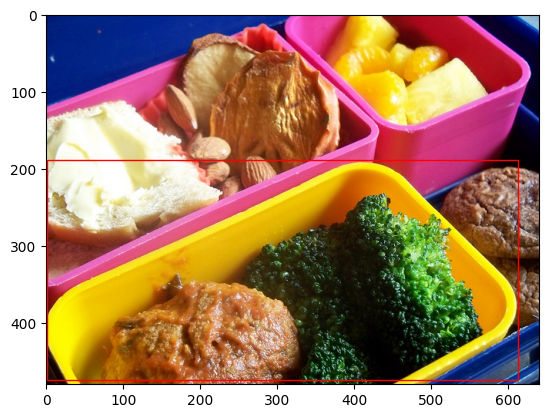

In [24]:
import matplotlib.patches as patches

fig, ax = plt.subplots()
ax.imshow(transforms.functional.to_pil_image(images[0]))

rect = patches.Rectangle((1.08, 187.69), 611.59, 285.84, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

In [ ]:
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)  # Returns predictions
print(predictions[0])

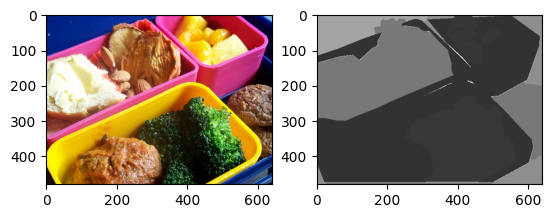

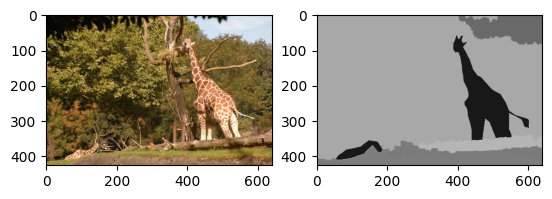

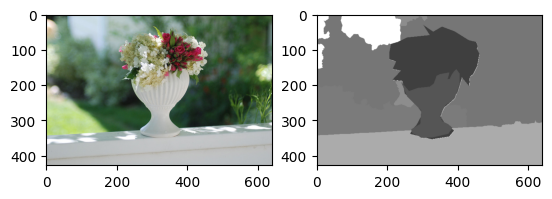

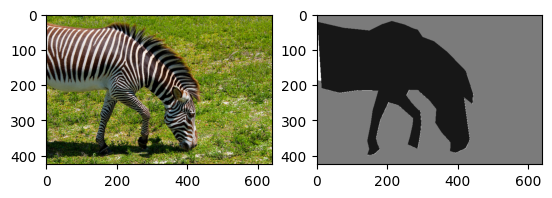

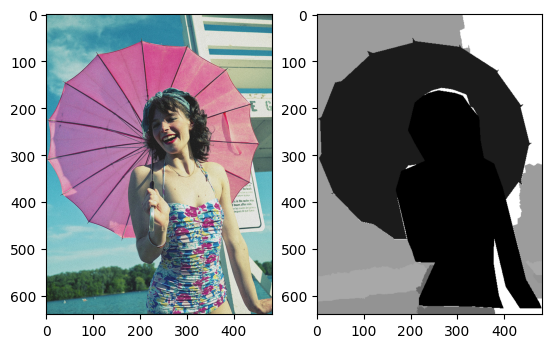

In [13]:
for x in range(len(dataset))[:5]:
    image, target = dataset[x]
    image = transforms.functional.to_pil_image(image)
    target = transforms.functional.to_pil_image(target)
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.imshow(image)
    ax2.imshow(target)

In [15]:
class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels) -> None:
        super().__init__()

        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x : torch.Tensor) -> torch.Tensor:
        return self.double_conv(x)
    
class ConvAndDownScale(nn.Module):
    def __init__(self, in_channels, out_channels) -> None:
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            ConvLayer(in_channels, out_channels)
        )

    def forward(self, x : torch.Tensor) -> torch.testing:
        # print(x.shape)
        return self.maxpool_conv(x)
    
class UpscaleAndConv(nn.Module):
    def __init__(self, in_channels, out_channels) -> None:
        super().__init__()
        self.upscale = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = ConvLayer(in_channels, out_channels)

    def forward(self, x1 : torch.Tensor, x2 : torch.Tensor) -> torch.Tensor:
        x1 = self.upscale(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [16]:
class UNet(nn.Module):
    def __init__(self, num_classes) -> None:
        super().__init__()
        self.down_conv_layer1 = ConvLayer(3, 64)
        self.down_conv_layer2 = ConvAndDownScale(64, 128)
        self.down_conv_layer3 = ConvAndDownScale(128, 256)
        self.down_conv_layer4 = ConvAndDownScale(256, 512)
        self.down_conv_layer5 = ConvAndDownScale(512, 1024)

        self.bridge = ConvLayer(1024, 1024)

        self.upscale = nn.Upsample(scale_factor=2)

        self.up_conv_layer1 = UpscaleAndConv(1024, 512)
        self.up_conv_layer2 = UpscaleAndConv(512, 256)
        self.up_conv_layer3 = UpscaleAndConv(256, 128)
        self.up_conv_layer4 = UpscaleAndConv(128, 64)

        self.tail = nn.Conv2d(64, num_classes, 1)

    def forward(self, x : torch.Tensor) -> torch.Tensor:
        x1 = self.down_conv_layer1(x)
        x2 = self.down_conv_layer2(x1)
        x3 = self.down_conv_layer3(x2)
        x4 = self.down_conv_layer4(x3)
        x5 = self.down_conv_layer5(x4)

        x_bridge = self.bridge(x5)

        x = self.up_conv_layer1(x_bridge, x4)
        x = self.up_conv_layer2(x, x3)
        x = self.up_conv_layer3(x, x2)
        x = self.up_conv_layer4(x, x1)

        y = self.tail(x)
        return y


In [17]:
image = transforms.functional.to_pil_image(result.squeeze(0))
target = transforms.functional.to_pil_image(target.squeeze(0))
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(image)
ax2.imshow(target)

NameError: name 'result' is not defined

In [18]:
LR = 0.001
WD = 1e-5
EPOCHS = 100
BATCH_SIZE = 16
momentum = 0.999

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=LR, weight_decay=WD, momentum=momentum, foreach=True)

In [19]:
dataset = CocoSegmentationDataset('train', transforms.Compose([transforms.ToTensor(), transforms.Resize((480, 640))]))
loader = DataLoader(dataset, batch_size=BATCH_SIZE)

dataset_valid = CocoSegmentationDataset('val', transforms.Compose([transforms.ToTensor(), transforms.Resize((480, 640))]))
loader_valid = DataLoader(dataset_valid, batch_size=1)

In [20]:
len(dataset)

1000

In [ ]:
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    valid_loss = 0
    for image, target in loader:
        image = image.to(device)
        target = target.to(device)

        output = model(image)
        # print(output.shape)
        # print(target.shape)
        loss = criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        optimizer.zero_grad()

    model.eval()
    with torch.no_grad:
        for image, target in loader_valid:
            image = image.to(device)
            target = target.to(device)
                    
            output = model(image)
            loss = criterion(output, target)

            valid_loss += loss.item()

    print(f"{epoch+1}/{EPOCHS}: train loss: {train_loss}, valid loss {valid_loss}.")